In [1]:
import os
from openeo_pg_parser.translate import translate_process_graph

First, we specify the input file path of the JSON file containing the process graph. 
In this case we want to parse a process graph, which loads S-2 data and computes the maximum NDVI value over a specific time span. 

In [2]:
pg_filepath = os.path.join("..", "tests", "process_graphs", "s2_max_ndvi.json")

### Parsing a Process Graph

We can now parse the process graph, i.e. convert it to a traversable graph object, by calling `translate_process_graph`. 

In [3]:
process_graph = translate_process_graph(pg_filepath)

Note that there are additional parameters for `translate_process_graph`:

* `process_defs`: This can be a list, dictionary, directory path or URL containing JSON file paths of process definitions. If this parameter is left empty, then the "processes" directory of the parser will be used.
* `parameters`: A dictionary of globally defined parameters, which can be accessed via 'from_parameter' from the process graph. By default this parameter remains `None`.
    
If you print the graph you get the information contained in each node.

In [4]:
print(process_graph)

Node ID: apply_0 
Node Name: apply 
{'arguments': {'data': {'from_node': 'reduce_time_7'},
               'process': {'from_node': 'linear_scale_range_1'}},
 'description': 'Stretch range from -1 / 1 to 0 / 255 for PNG visualization.',
 'process_id': 'apply'}

Node ID: linear_scale_range_1 
Node Name: linear_scale_range 
{'arguments': {'inputMax': 1,
               'inputMin': -1,
               'outputMax': 255,
               'x': {'from_parameter': 'x'}},
 'process_id': 'linear_scale_range',
 'result': True}

Node ID: load_collection_2 
Node Name: load_collection 
{'arguments': {'bands': ['B4', 'B8'],
               'id': 'COPERNICUS/S2',
               'spatial_extent': {'coordinates': [[[7.246856689453125,
                                                    47.167543112150554],
                                                   [7.218189239501953,
                                                    47.13520594493793],
                                                   [7.235527038

There are not only nodes in the graph, also edges establishing a link between nodes. The graph contains two relevant edges, the "data" edges basically representing input data flow and the "process" edges introduce processing dependencies. In other words a process has to wait until its parent process is complete.

### Plotting a Process Graph

The process graph object also allows you to plot the graph and modify the way how it is displayed. By default, the "kamada_kawai" algorithm is used to place the vertices and edges. You can display specific edges by specifying `edge_name="data"` or `edge_name="process"`.

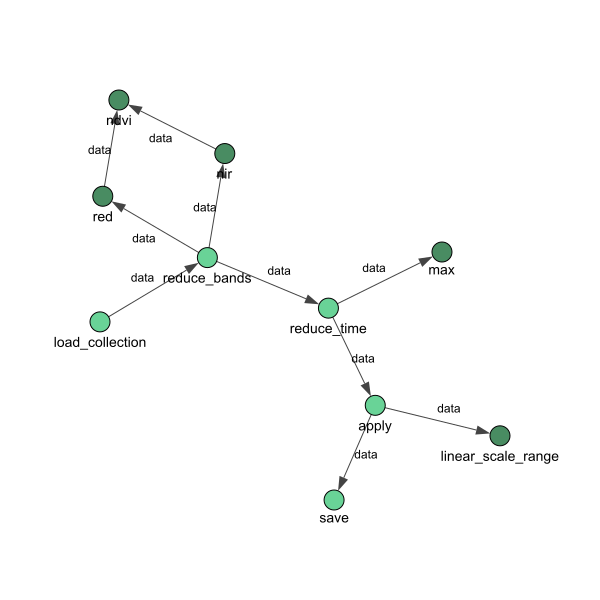

In [5]:
process_graph.plot(edge_name="data")

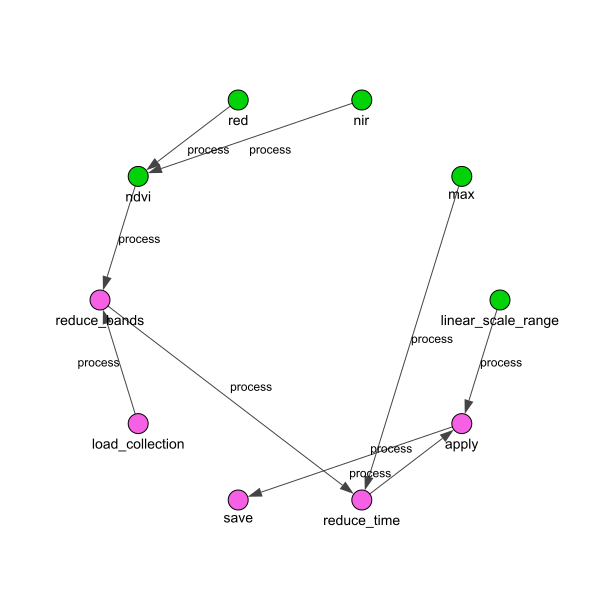

In [6]:
process_graph.plot(layout="circle", edge_name="process")

### Sorting a Process Graph

It also possible to sort the process graph by the dependency of each node
with

In [7]:
sorted_process_graph = process_graph.sort(by='dependency')
print(sorted_process_graph)

Node ID: load_collection_2 
Node Name: load_collection 
{'arguments': {'bands': ['B4', 'B8'],
               'id': 'COPERNICUS/S2',
               'spatial_extent': {'coordinates': [[[7.246856689453125,
                                                    47.167543112150554],
                                                   [7.218189239501953,
                                                    47.13520594493793],
                                                   [7.23552703857422,
                                                    47.11570074493338],
                                                   [7.2803306579589835,
                                                    47.11488300552253],
                                                   [7.305736541748048,
                                                    47.14793302647546],
                                                   [7.279300689697265,
                                                    47.16999386399103],
         

### Node Properties

If you are interested in a specific node, you can use Python indexing with the node ID

In [8]:
print(process_graph['reduce_time_7'])

Node ID: reduce_time_7 
Node Name: reduce_time 
{'arguments': {'data': {'from_node': 'reduce_bands_3'},
               'dimension': 't',
               'reducer': {'from_node': 'max_8'}},
 'description': 'Compute a minimum time composite by reducing the temporal '
                'dimension',
 'process_id': 'reduce_dimension'}


or the node name, if it is unique

In [9]:
print(process_graph['reduce_time'])

Node ID: reduce_time_7 
Node Name: reduce_time 
{'arguments': {'data': {'from_node': 'reduce_bands_3'},
               'dimension': 't',
               'reducer': {'from_node': 'max_8'}},
 'description': 'Compute a minimum time composite by reducing the temporal '
                'dimension',
 'process_id': 'reduce_dimension'}


All relevant node attributes can directly be accessed. 

In [10]:
reduce_node = process_graph['reduce_time_7']

The process ID,

In [11]:
reduce_node.process_id

'reduce_dimension'

the namespace (`None` in this case),

In [12]:
reduce_node.namespace

process arguments,

In [13]:
reduce_node.arguments

{'data': {'from_node': 'reduce_bands_3'},
 'reducer': {'from_node': 'max_8'},
 'dimension': 't',
 'context': None}

its description,

In [14]:
reduce_node.description

'Compute a minimum time composite by reducing the temporal dimension'

if it is a reducer,

In [15]:
reduce_node.is_reducer

True

the dimension to reduce along (only if `reduce_node.is_reducer` is `True`),

In [16]:
reduce_node.dimension

't'

and finally if it is a result node.

In [17]:
reduce_node.is_result

False

### Node Relationships

A node also offers access to its relatives. This can for instance be a
sub-graph containing all node dependencies. Dependencies in this context are direct relationships of nodes through "process" edges, meaning that this node is done or can start processing as soon as the dependent process is finished.

In [18]:
print(process_graph['reduce_time_7'].dependencies)

Node ID: max_8 
Node Name: max 
{'arguments': {'data': {'from_parameter': 'data'}},
 'process_id': 'max',
 'result': True}

Node ID: reduce_bands_3 
Node Name: reduce_bands 
{'arguments': {'data': {'from_node': 'load_collection_2'},
               'dimension': 'bands',
               'reducer': {'from_node': 'ndvi_6'}},
 'description': 'Compute the NDVI: (NIR - RED) / (NIR + RED)',
 'process_id': 'reduce_dimension'}




Most relationship results are again a valid graph object, thus you can plot it.

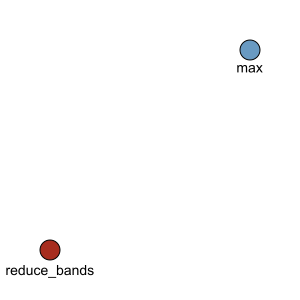

In [19]:
process_graph['reduce_time_7'].dependencies.plot(edge_name="process", bbox=(0, 0, 300, 300), margin=50)

The dependencies can be further separated into:
* nodes where input data for current node is produced and 
* nodes which are only callbacks and their data simply needs to be passed further by the current node

The first set of nodes can be accessed with

In [20]:
print(process_graph['reduce_time_7'].input_data_processes)

Node ID: reduce_bands_3 
Node Name: reduce_bands 
{'arguments': {'data': {'from_node': 'load_collection_2'},
               'dimension': 'bands',
               'reducer': {'from_node': 'ndvi_6'}},
 'description': 'Compute the NDVI: (NIR - RED) / (NIR + RED)',
 'process_id': 'reduce_dimension'}




and the second set with

In [21]:
print(process_graph['reduce_time_7'].result_processes)

Node ID: max_8 
Node Name: max 
{'arguments': {'data': {'from_parameter': 'data'}},
 'process_id': 'max',
 'result': True}




which are the "result" nodes one level below the current node.

A node can have one callback to several processing nodes. For instance "reduce_time" calls "max" and "reduce_bands" calls "red", "nir", and "ndvi". This can be accessed via

In [22]:
print(process_graph['reduce_bands_3'].child_processes)

Node ID: red_4 
Node Name: red 
{'arguments': {'data': {'from_parameter': 'data'}, 'label': 'B4'},
 'process_id': 'array_element'}

Node ID: nir_5 
Node Name: nir 
{'arguments': {'data': {'from_parameter': 'data'}, 'label': 'B8'},
 'process_id': 'array_element'}

Node ID: ndvi_6 
Node Name: ndvi 
{'arguments': {'x': {'from_node': 'nir_5'}, 'y': {'from_node': 'red_4'}},
 'process_id': 'normalized_difference',
 'result': True}




and the other way around

In [23]:
print(process_graph['nir_5'].parent_process)

Node ID: reduce_bands_3 
Node Name: reduce_bands 
{'arguments': {'data': {'from_node': 'load_collection_2'},
               'dimension': 'bands',
               'reducer': {'from_node': 'ndvi_6'}},
 'description': 'Compute the NDVI: (NIR - RED) / (NIR + RED)',
 'process_id': 'reduce_dimension'}


Note that the return value is not a graph.